===================linear-regression.md=========================

In [85]:
%matplotlib inline

import math
import torch
from torch import nn
import numpy as np
import time
import matplotlib.pyplot as plt
from d2l import torch as d2l

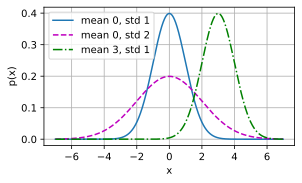

In [86]:
# Fixed normal distribution plotting
def normal(x, mu, sigma):
    """Calculate normal distribution probability density function"""
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

# Generate x values for plotting
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

# Use d2l.plot, it will loop through y and plot curve sequencely
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], 
         xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [ ]:
# Minimizing the mean squared error is equivalent to the maximum likelihood estimation of a linear model under the assumption of additive Gaussian noise !!!!

===============================oo-design.md==================================================

In [87]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [88]:
class A:
    def __init__(self):
        self.b = 1

a = A()

@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [89]:
### OR manually
class C:
    def __init__(self):
        self.b = 999

# Step 2: Define a function we want to add to the class
def manual_do(self):
    print(f'Manual method: Class attribute "b" is {self.b}')

C.manual_do = manual_do

c = C()
c.manual_do()

Manual method: Class attribute "b" is 999


In [90]:
from d2l import torch as d2l

class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented
    
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [91]:
# 🎯 CONCISE EXPLANATION: inspect.currentframe().f_back
print("="*60)
print("💡 QUICK SUMMARY FOR THOSE WHO KNOW CALL STACKS")
print("="*60)

import inspect

print("🔍 What it does:")
print("• inspect.currentframe() = current function's frame")
print("• .f_back = caller's frame (one level up the stack)")
print("• inspect.getargvalues(frame) = extract caller's variables")

print(f"\n⚡ The magic:")
print("save_hyperparameters() can access __init__'s local variables")
print("→ Automatically: self.param1 = param1, self.param2 = param2, ...")

print(f"\n🎯 Result:")
print("Instead of manual assignments, one call does it all!")

# Minimal working example
class QuickDemo(d2l.HyperParameters):
    def __init__(self, lr, batch_size, epochs):
        self.save_hyperparameters()  # ← f_back magic happens here
        print(f"✅ Auto-saved: lr={self.lr}, batch_size={self.batch_size}, epochs={self.epochs}")

demo = QuickDemo(0.01, 64, 100)

💡 QUICK SUMMARY FOR THOSE WHO KNOW CALL STACKS
🔍 What it does:
• inspect.currentframe() = current function's frame
• .f_back = caller's frame (one level up the stack)
• inspect.getargvalues(frame) = extract caller's variables

⚡ The magic:
save_hyperparameters() can access __init__'s local variables
→ Automatically: self.param1 = param1, self.param2 = param2, ...

🎯 Result:
Instead of manual assignments, one call does it all!
✅ Auto-saved: lr=0.01, batch_size=64, epochs=100


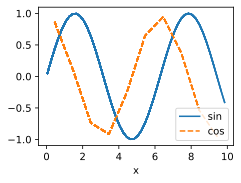

In [92]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented
    
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [93]:
class Module(d2l.nn_Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())), ('train_' if train else 'val_') + key, every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
       ### IF unpack above:
       ### Given a batch from DataLoader:
       ### batch = (X, y)  # X: features, y: targets

       ### Step 1: Extract features and targets
       ### features = batch[:-1]  # (X,)
       ### targets = batch[-1]    # y

       ### Step 2: Forward pass - get predictions
       ### The * unpacks the tuple: *feature: X
       ### Then invoke nn.Module.__call__ method, which will call into .forward method
       ### predictions = self(*features)  # self(X) → y_hat

       ### Step 3: Calculate loss
       ### loss_value = self.loss(predictions, targets)  # loss(y_hat, y)

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [105]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
            self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [106]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

=========================synthetic-regression-data.md===============================

In [110]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = d2l.randn(n, len(w))
        noise = d2l.randn(n, 1) * noise

        # d2l.reshape(w, (-1, 1)) converts the 1D weight vector into a 2D column vector， [2, -3.4] -> w = [[2], [-3.4]]   # Shape: (2, 1)
        # -1 will infer 2.
        self.y = d2l.matmul(self.X, d2l.reshape(w, (-1, 1))) + b + noise

data = SyntheticRegressionData(w=d2l.tensor([2, -3.4]), b=4.2)
data.X, data.y

(tensor([[-2.5033,  0.3783],
         [ 0.7073, -0.3145],
         [-0.9441, -0.4715],
         ...,
         [ 0.1508, -1.0221],
         [ 1.1623, -0.5075],
         [ 0.8865, -0.4830]]),
 tensor([[-2.0862],
         [ 6.6915],
         [ 3.9020],
         ...,
         [ 7.9816],
         [ 8.2527],
         [ 7.6076]]))

In [111]:
import random

### Manual 

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    print(indices)
    for i in range(0, len(indices), self.batch_size):
        batch_indices = d2l.tensor(indices[i: i+self.batch_size])
        print("batch_indices.shape", batch_indices.shape)
        yield self.X[batch_indices], self.y[batch_indices]

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

[952, 119, 524, 105, 977, 756, 812, 222, 715, 152, 521, 271, 859, 587, 752, 928, 156, 609, 366, 169, 24, 549, 771, 640, 948, 723, 59, 823, 636, 620, 183, 278, 852, 343, 762, 163, 412, 201, 84, 128, 96, 873, 697, 406, 498, 221, 274, 272, 946, 867, 437, 684, 17, 688, 575, 459, 825, 419, 836, 172, 962, 160, 207, 584, 73, 411, 58, 344, 647, 62, 841, 935, 957, 523, 310, 849, 209, 534, 747, 494, 46, 706, 188, 173, 566, 632, 447, 485, 286, 47, 0, 36, 174, 410, 2, 258, 874, 622, 629, 820, 422, 223, 153, 652, 993, 739, 67, 814, 714, 865, 198, 134, 615, 934, 876, 257, 743, 451, 90, 244, 354, 78, 241, 897, 539, 907, 11, 750, 845, 818, 465, 157, 628, 903, 307, 388, 368, 352, 288, 976, 313, 842, 889, 915, 111, 664, 766, 574, 486, 879, 56, 768, 806, 473, 50, 586, 395, 367, 999, 853, 10, 551, 857, 424, 649, 542, 861, 252, 830, 138, 99, 882, 240, 230, 808, 40, 203, 654, 261, 277, 116, 718, 496, 544, 391, 348, 248, 85, 997, 910, 583, 821, 41, 458, 137, 456, 16, 789, 129, 25, 601, 478, 457, 506, 415, 47

In [114]:
### PyTorch DataLoader Implementation 

@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    # tensors: tuple of tensors (X, y) - our actual data
    # indices: slice object
    tensors = tuple(a[indices] for a in tensors)
    
    dataset = torch.utils.data.TensorDataset(*tensors)

    # Creates optimized DataLoader with:
    #  • Automatic batching (batch_size)"
    #  • Optional shuffling (shuffle=train)"
    #  • C++ backend for performance"
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    # slice(0, 1000) = first 1000 samples; slice(1000, None) = samples 1000 to end
    indices = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, indices)


X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
len(data.train_dataloader())

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


32

In [115]:
print("📋 Manual Implementation(Educational/manual approach):")
print("• Manual random shuffling with random.shuffle()")
print("• Manual batch creation with slicing")
print("• Python loops and list operations")
print("• No parallelization")
print("• Memory inefficient (creates intermediate lists: indices, batch_indices, The sliced list from indices[i: i+self.batch_size] - This creates yet another temporary list before converting to tensor)")

print(f"\n🚀 PyTorch DataLoader(Production-ready, optimized approach):")
print("• Uses torch.utils.data.TensorDataset")
print("• Uses torch.utils.data.DataLoader")
print("• Optimized C++ backend")
print("• Multi-threading support (num_workers)")
print("• Memory-efficient batch loading")

print("1️⃣ TensorDataset: Direct tensor indexing (no Python lists)")
print("2️⃣ DataLoader: C++ optimized batching and shuffling")
print("3️⃣ Memory efficient: No intermediate copies")
print("4️⃣ Lazy loading: Batches created on-demand")
print("5️⃣ GPU ready: Works seamlessly with CUDA tensors")

print(f"\n⚡ KEY EFFICIENCY GAINS")
print("1️⃣ Native PyTorch operations (faster than Python)")
print("2️⃣ Parallel data loading capability")
print("3️⃣ Memory optimization (no intermediate lists)")
print("4️⃣ GPU-ready tensors")
print("5️⃣ Built-in shuffling algorithms")

📋 Manual Implementation(Educational/manual approach):
• Manual random shuffling with random.shuffle()
• Manual batch creation with slicing
• Python loops and list operations
• No parallelization
• Memory inefficient (creates intermediate lists: indices, batch_indices, The sliced list from indices[i: i+self.batch_size] - This creates yet another temporary list before converting to tensor)

🚀 PyTorch DataLoader(Production-ready, optimized approach):
• Uses torch.utils.data.TensorDataset
• Uses torch.utils.data.DataLoader
• Optimized C++ backend
• Multi-threading support (num_workers)
• Memory-efficient batch loading
1️⃣ TensorDataset: Direct tensor indexing (no Python lists)
2️⃣ DataLoader: C++ optimized batching and shuffling
3️⃣ Memory efficient: No intermediate copies
4️⃣ Lazy loading: Batches created on-demand
5️⃣ GPU ready: Works seamlessly with CUDA tensors

⚡ KEY EFFICIENCY GAINS
1️⃣ Native PyTorch operations (faster than Python)
2️⃣ Parallel data loading capability
3️⃣ Memory opt

=================================================linear-regression-scratch.md==========================================================

In [122]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = d2l.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = d2l.zeros(1, requires_grad=True)


@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return d2l.matmul(X, self.w) + self.b

@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return d2l.reduce_mean(l)

class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        # self.params = [self.w, self.b]; self.params contains references to the actual tensors
        for param in self.params:
            # will modify original tensor, Equivalent to: param.data = param.data - self.lr * param.grad
            # In-place modification
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

data.batch_size:  32
train_loader.num_train_batches:  32
error in estimating w: tensor([ 0.1051, -0.1990])
error in estimating b: tensor([0.2496])


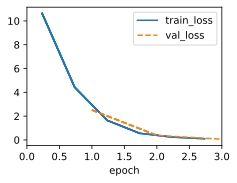

In [125]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:        
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():            
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=d2l.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

print("data.batch_size: ", data.batch_size)
print("train_loader.num_train_batches: ", trainer.num_train_batches)
with torch.no_grad():
    print(f'error in estimating w: {data.w - d2l.reshape(model.w, data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

===========================================linear-regression-concise.md====================================================

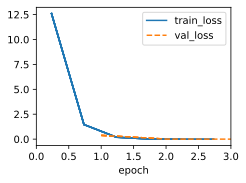

In [127]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=d2l.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [130]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)

w, b = model.get_w_b()
print(f'error in estimating w: {data.w - d2l.reshape(w, data.w.shape)}')
print(f'error in estimating b: {data.b - b}')
print(data.w)
print(data.b)

error in estimating w: tensor([ 0.0036, -0.0035])
error in estimating b: tensor([0.0079])
tensor([ 2.0000, -3.4000])
4.2


============================================generalization.md=======================================

In [ ]:
# training error:  a statistic calculated on the training dataset
# generalization error R: an expectation taken with respect to the underlying distribution. 
# You can think of the generalization error as what you would see if you applied your model to an infinite stream of additional data examples drawn from the same underlying data distribution.

# we can never calculate the generalization error R exactly. 
# we must estimate the generalization error by applying our model to an independent TEST SET constituted of a random selection of examples X' and labels y' that were withheld from our training set. 

# Use validation sets(or K-fold cross-validation)  for model selection;

In [133]:
# K-fold cross-validation: when we might not even be able to afford to hold out enough data to constitute a proper validation set. Here, the original training data is split into 
# K non-overlapping subsets. Then model training and validation are executed K times, each time training on K−1 subsets and validating on a different subset (the one not used for
# training in that round). Finally, the training and validation errors are estimated by averaging over the results from the K experiments.

=====================================================weight-decay.md================================================

In [ ]:
# weight decay: L2 normalization

In [135]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()                
        n = num_train + num_val 
        
        self.X = d2l.randn(n, num_inputs)
        noise = d2l.randn(n, 1) * 0.01
        w, b = d2l.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = d2l.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)
    
def l2_penalty(w):
    return d2l.reduce_sum(w**2) / 2

class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()
        
    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))
    
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):    
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010944097302854061


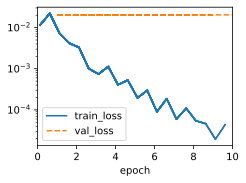

In [ ]:
# [Training without Regularization]
train_scratch(0)

# we overfit badly, decreasing the training error but not the validation error---a textbook case of overfitting.

L2 norm of w: 0.001736782374791801


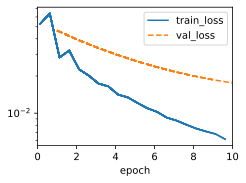

In [ ]:
# use weight decay:
train_scratch(3)

L2 norm of w: 0.015481696464121342


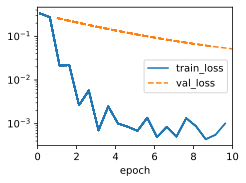

In [138]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)
    
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)


print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))